In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.image_utils import array_to_img, img_to_array, load_img
from keras import backend as K
from keras import metrics
from imgaug import augmenters as iaa

2023-03-29 23:57:02.761839: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 23:57:02.789702: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-29 23:57:02.790279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 23:57:03.321122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
 # Set some parameters
im_width = 128
im_height = 128
border = 5

In [3]:
ids = next(os.walk("Tissue_Images"))[2] # list of names all images in the given path
idm= next(os.walk("Nuclei_Masks"))[2]
print("No. of images = ", len(ids))
print("No. of masks = ", len(idm))

No. of images =  37
No. of masks =  37


In [4]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)


In [5]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    #print(id_)
    # Load images
    img = load_img("Tissue_Images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    x_img = x_img.astype('float32')
    X[n] = x_img/255.0
    
for n, id_ in tqdm_notebook(enumerate(idm), total=len(idm)):
    #print(id_)
    # Load Nuclei masks
    mask = img_to_array(load_img("Nuclei_Masks/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    mask=mask.astype('float32')
    # Save images
    y[n] = mask/255.0

/tmp/ipykernel_382074/4108123683.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/37 [00:00<?, ?it/s]

/home/soumitra/anaconda3/lib/python3.8/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
/tmp/ipykernel_382074/4108123683.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(idm), total=len(idm)):


  0%|          | 0/37 [00:00<?, ?it/s]

In [6]:
X.shape, y.shape


((37, 128, 128, 1), (37, 128, 128, 1))

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [8]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [10]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
opt = SGD(lr=0.01, momentum=0.9)
#opt=Adam()
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", dice_coef])

2023-03-29 23:57:24.052117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/soumitra/anaconda3/lib/python3.8/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

                                                                                                  
 batch_normalization_13 (BatchN  (None, 32, 32, 64)  256         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 64, 64, 32)  18464       ['activation_13[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 64, 64, 64)   0           ['conv2d_transpose_2[0][0]',     
          

In [12]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [13]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-soumitra-nuclei_experiment3.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [14]:
    # Image augmentation
    # http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

In [15]:
# create data generator
datagen = ImageDataGenerator(augmentation)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=16)
# fit model
results=model.fit_generator(it_train, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))
#results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
#                   augmentation=augmentation, validation_data=(X_valid, y_valid))

Epoch 1/50


/tmp/ipykernel_382074/3388700159.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results=model.fit_generator(it_train, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))
/home/soumitra/anaconda3/lib/python3.8/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
2023-03-29 23:57:47.882137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - ETA: 0s - loss: 0.9472 - accuracy: 0.0372 - dice_coef: 0.3743
Epoch 1: val_loss improved from inf to 0.67424, saving model to model-soumitra-nuclei_experiment3.h5
2/2 [==============================] - 2s 730ms/step - loss: 0.9472 - accuracy: 0.0372 - dice_coef: 0.3743 - val_loss: 0.6742 - val_accuracy: 0.2290 - val_dice_coef: 0.2759 - lr: 0.0100
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 0.0419 - dice_coef: 0.3736
Epoch 2: val_loss improved from 0.67424 to 0.66728, saving model to model-soumitra-nuclei_experiment3.h5
2/2 [==============================] - 1s 477ms/step - loss: 0.9206 - accuracy: 0.0419 - dice_coef: 0.3736 - val_loss: 0.6673 - val_accuracy: 0.2469 - val_dice_coef: 0.2748 - lr: 0.0100
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.8819 - accuracy: 0.0464 - dice_coef: 0.3696
Epoch 3: val_loss improved from 0.66728 to 0.65714, saving model to model-soumitra-nuclei_experim

Epoch 22/50
2/2 [==============================] - ETA: 0s - loss: 0.6094 - accuracy: 0.1847 - dice_coef: 0.2639
Epoch 22: val_loss did not improve from 0.53581
2/2 [==============================] - 1s 420ms/step - loss: 0.6094 - accuracy: 0.1847 - dice_coef: 0.2639 - val_loss: 0.5391 - val_accuracy: 0.3090 - val_dice_coef: 0.2430 - lr: 0.0100
Epoch 23/50
2/2 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.1848 - dice_coef: 0.2648
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 23: val_loss did not improve from 0.53581
2/2 [==============================] - 1s 450ms/step - loss: 0.6065 - accuracy: 0.1848 - dice_coef: 0.2648 - val_loss: 0.5407 - val_accuracy: 0.3090 - val_dice_coef: 0.2438 - lr: 0.0100
Epoch 24/50
2/2 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.1848 - dice_coef: 0.2662
Epoch 24: val_loss did not improve from 0.53581
2/2 [==============================] - 1s 452ms/step - loss: 0.6062

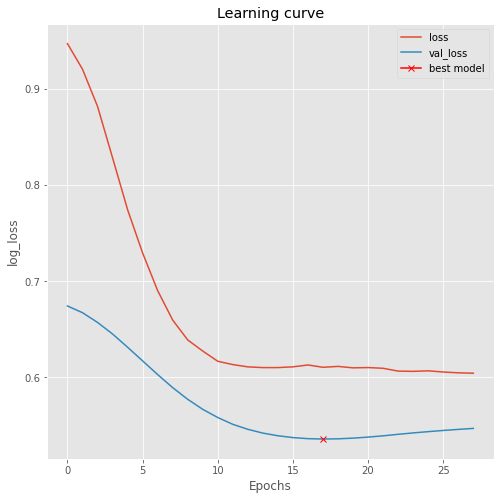

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [17]:
# load the best model
model.load_weights('model-soumitra-nuclei_experiment3.h5')

In [18]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 41ms/step - loss: 0.5358 - accuracy: 0.3090 - dice_coef: 0.2411


[0.5358059406280518, 0.308990478515625, 0.24114155769348145]

In [19]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


1/1 [==============================] - 0s 38ms/step


In [20]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [21]:
X_valid.shape

(6, 128, 128, 1)

In [22]:
preds_train.shape

(31, 128, 128, 1)

In [23]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Tissue Images')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Nucleus')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Nucleus Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Nucleus Predicted binary');

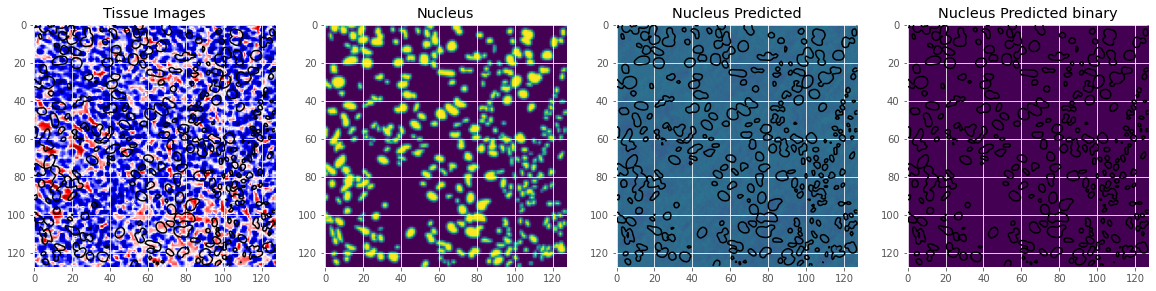

In [24]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=2)

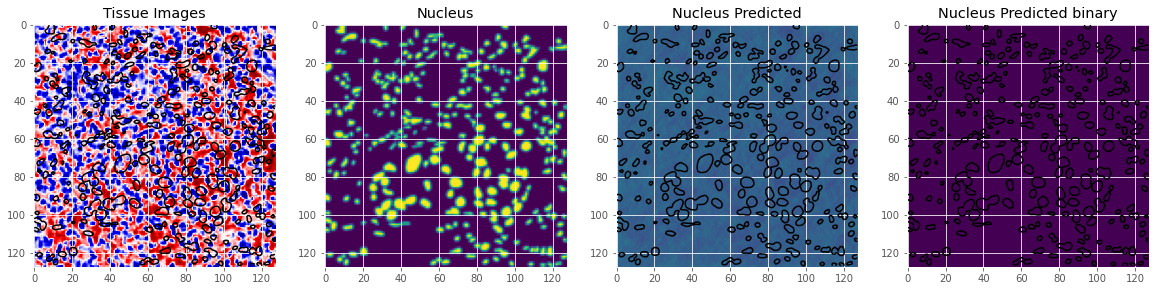

In [25]:
# Check if validation data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=2)

# Inference

In [26]:
idf = next(os.walk("Inference"))[2]
print("No. of Inferences = ", len(idf))

No. of Inferences =  1


In [27]:
#Process whole slide images
import openslide
from PIL import Image
import skimage
import imageio
import os,sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from PIL import Image
import scipy
import scipy.ndimage
from openslide.deepzoom import DeepZoomGenerator
files=glob.glob("Inference/*.svs")

Vendor is: aperio
Pixel size of X in um is: 0.2457
Pixel size of Y in um is: 0.2457
(19920, 18542)
((19920, 18542), (4980, 4635), (2490, 2317))
(1.0, 4.000215749730312, 8.001294777729823)


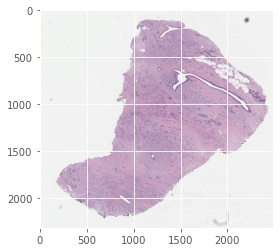

In [28]:
image_name = files[0]
slide = openslide.OpenSlide(image_name)
slide_props=slide.properties
#print(slide_props)

print("Vendor is:", slide_props['openslide.vendor'])
print("Pixel size of X in um is:", slide_props['openslide.mpp-x'])
print("Pixel size of Y in um is:", slide_props['openslide.mpp-y'])

#Get slide dimensions for level 0
slide_dims=slide.dimensions
print(slide_dims)

#Get Slide dimensios at each level
dims=slide.level_dimensions
print(dims)

#How much are levels downsampled from the original image
factors=slide.level_downsamples
print(factors)

#Copy an image from a level
level13_dim=dims[2]

level13_img=slide.read_region((0,0), 2, level13_dim)

#Convert the image into RGB
level13_img_rgb=level13_img.convert('RGB')

image=np.array(level13_img_rgb)
plt.imshow(image)
plt.show()

#Return the best level for downsampling the given sample
scale_factor=32
best_level=slide.get_best_level_for_downsample(scale_factor)

8001 4000
(200, 200)


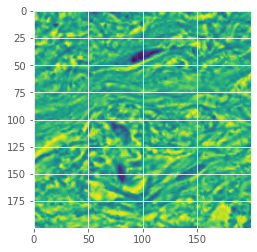

In [29]:
#Extract 200*200 patch from a random x,y location
xp,yp = int(1000*factors[2]),int(500*factors[2])
print(xp,yp)
patch_size = 200
level=2
im_patch = np.array(slide.read_region((xp,yp),0,(patch_size,patch_size)).convert('L')) 
print(im_patch.shape)
plt.imshow(im_patch)

In [30]:
imgs = img_to_array(im_patch)
imgs = resize(imgs, (128, 128, 1), mode = 'constant', preserve_range = True)
print(imgs.shape)
imgp = imgs.reshape(1, 128, 128, 1)
print(imgp.shape)
#plt.imshow(imgp)

(128, 128, 1)
(1, 128, 128, 1)


In [ ]:
# Run detection and predict nuclei on a inference patch
imgp = imgp*255.0
# load the best model
model.load_weights('model-soumitra-nuclei_experiment4.h5')
predicted_nuclei = model.predict([imgp], verbose=1)
# Threshold predictions
predicted_nuclei_t = (predicted_nuclei > 0.5).astype(np.uint8)

/home/soumitra/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


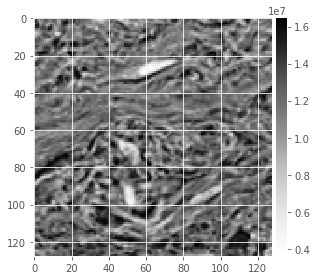

/home/soumitra/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


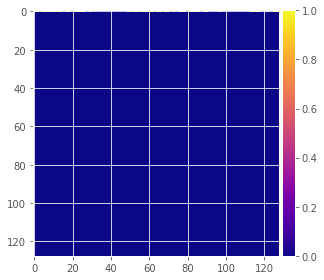

In [32]:
imshow(imgp[0,...,0], cmap='Greys')
plt.show()
imshow(predicted_nuclei[0].squeeze().astype(np.uint8), cmap='plasma')
plt.show()